In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
from pathlib import Path
import sys
sys.path.append(str(Path.cwd() / "_scripts"))

In [19]:
import seaborn as sns
import seaborn.objects as so
import polars as pl
import numpy as np
import matplotlib.pyplot as plt

from helpers.variable_interfaces import all_variables as vars

# from setup.data_wrangle import *
# from setup.materials_setup import *
# from analysis.dataframes import *
# from analysis.volumes import *

from experiments.comparisons import EXP_GROUP
from experiments.retrieve import retrieve_comparison_groups, retrieve_control_cases, get_experiment_folders
from experiments.name_splits import *
# sns.set_style("darkgrid")

from analysis2.all_cases_v_time import create_space_and_site_dfs
from setup.data_wrangle2 import create_wide_dataframe_for_many_qois_and_cases

from experiments.scatter import create_plots_for_comparison_group, save_plots_for_all_experiments, create_comparison_df
from typing import get_args



In [23]:
vals = create_plots_for_comparison_group("doors")
vals 

In [24]:
create_comparison_df.cache_info()

CacheInfo(hits=1, misses=1, maxsize=128, currsize=1)

In [ ]:
# save_plots_for_all_experiments()

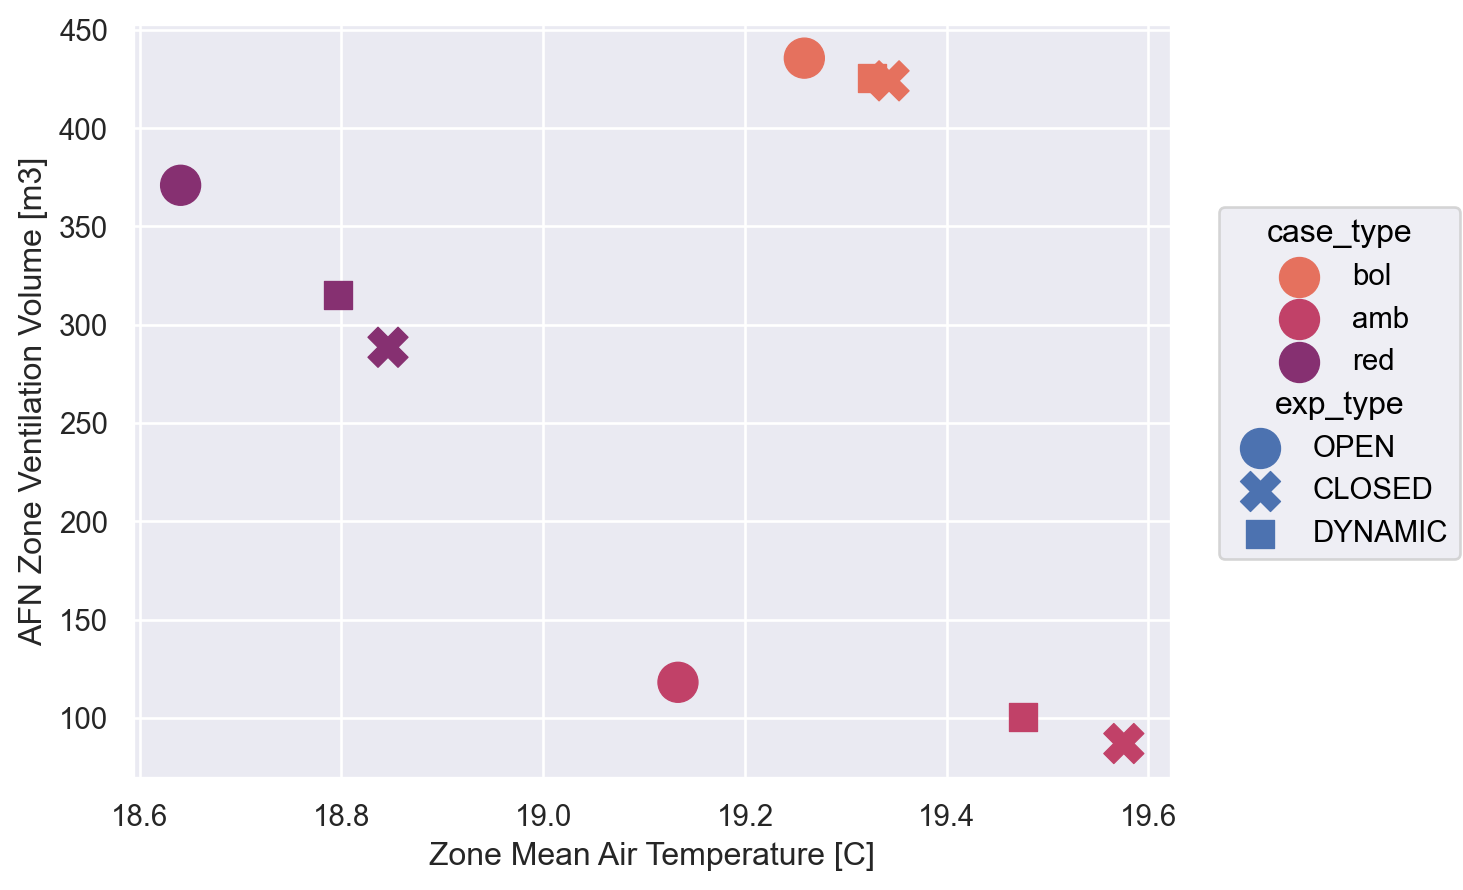

In [9]:
vals[0]

In [ ]:
# save_plots_for_all_experiments()

## s

In [13]:
exp_folders

[PosixPath('/Users/julietnwagwuume-ezeoke/_UILCode/gqe-phd/geomeppy/cases/241120_summer_windows'),
 PosixPath('/Users/julietnwagwuume-ezeoke/_UILCode/gqe-phd/geomeppy/cases/241120_summer_doors'),
 PosixPath('/Users/julietnwagwuume-ezeoke/_UILCode/gqe-phd/geomeppy/cases/241120_summer_materials')]

In [25]:
cases = retrieve_comparison_groups("doors", ep)
cases

# get_experiment_folders()

[CaseData(case_name='bol_5_CLOSED', idf=<geomeppy.idf.IDF object at 0x13be272e0>, sql=Energy SQLiteResult: /Users/julietnwagwuume-ezeoke/_UILCode/gqe-phd/geomeppy/cases/241120_summer_doors/bol_5_CLOSED/results/eplusout.sql, path_to_input=PosixPath('/Users/julietnwagwuume-ezeoke/_UILCode/gqe-phd/svg2plan/outputs2/case_bol_5'), path_to_output=PosixPath('/Users/julietnwagwuume-ezeoke/_UILCode/gqe-phd/geomeppy/cases/241120_summer_doors/bol_5_CLOSED')),
 CaseData(case_name='amb_b1_DYNAMIC', idf=<geomeppy.idf.IDF object at 0x318072380>, sql=Energy SQLiteResult: /Users/julietnwagwuume-ezeoke/_UILCode/gqe-phd/geomeppy/cases/241120_summer_doors/amb_b1_DYNAMIC/results/eplusout.sql, path_to_input=PosixPath('/Users/julietnwagwuume-ezeoke/_UILCode/gqe-phd/svg2plan/outputs2/case_amb_b1'), path_to_output=PosixPath('/Users/julietnwagwuume-ezeoke/_UILCode/gqe-phd/geomeppy/cases/241120_summer_doors/amb_b1_DYNAMIC')),
 CaseData(case_name='red_b1_DYNAMIC', idf=<geomeppy.idf.IDF object at 0x318379f00>, sql

In [26]:
df_temp = create_wide_dataframe_for_many_qois_and_cases(cases, [vars.zone.temp["zone_mean_air_temp"]])

df, df_site = create_space_and_site_dfs(cases=cases, space_qois=[vars.afn.zone["vent_vol"], vars.afn.zone["mix_vol"]], site_qois=[vars.site.wind["speed"]])

In [27]:
df_vol = df.join(df_temp, on=["case_names", "space_names", "datetimes"]).with_columns(combined_vent =pl.col("AFN Zone Ventilation Volume [m3]") + pl.col("AFN Zone Mixing Volume [m3]"))
df_vol.head()

case_names,space_names,datetimes,AFN Zone Ventilation Volume [m3],AFN Zone Mixing Volume [m3],time,Zone Mean Air Temperature [C],combined_vent
str,str,datetime[μs],f64,f64,str,f64,f64
"""bol_5_CLOSED""","""BLOCK 00 STOREY 0""",2017-06-01 00:00:00,720.075902,0.0,"""00:00""",14.57927,720.075902
"""bol_5_CLOSED""","""BLOCK 00 STOREY 0""",2017-06-01 00:15:00,610.012064,0.0,"""00:15""",15.103653,610.012064
"""bol_5_CLOSED""","""BLOCK 00 STOREY 0""",2017-06-01 00:30:00,506.386227,0.0,"""00:30""",15.630227,506.386227
"""bol_5_CLOSED""","""BLOCK 00 STOREY 0""",2017-06-01 00:45:00,409.343669,0.0,"""00:45""",16.151335,409.343669
"""bol_5_CLOSED""","""BLOCK 00 STOREY 0""",2017-06-01 01:00:00,379.543861,0.0,"""01:00""",16.040267,379.543861


In [28]:
len(df_vol)

1233792

In [29]:
df_agg = df_vol.group_by("case_names").agg([pl.mean("AFN Zone Ventilation Volume [m3]"),
pl.mean("AFN Zone Mixing Volume [m3]"),
pl.mean("combined_vent"), 
pl.mean("Zone Mean Air Temperature [C]")
])


In [30]:
df_agg = split_by_doors(split_by_case_type(df_agg))
df_agg

case_names,AFN Zone Ventilation Volume [m3],AFN Zone Mixing Volume [m3],combined_vent,Zone Mean Air Temperature [C],case_type,exp_type
str,f64,f64,f64,f64,str,str
"""bol_5_CLOSED""",423.976704,87.013539,510.990243,19.342888,"""bol""","""CLOSED"""
"""bol_5_DYNAMIC""",425.534528,166.058424,591.592952,19.326158,"""bol""","""DYNAMIC"""
"""red_b1_CLOSED""",288.488941,169.385862,457.874803,18.846131,"""red""","""CLOSED"""
"""red_b1_Medium""",370.86455,515.112102,885.976652,18.640518,"""red""","""OPEN"""
"""amb_b1_CLOSED""",86.981924,191.884485,278.866409,19.575641,"""amb""","""CLOSED"""
"""amb_b1_Medium""",118.120114,411.156259,529.276372,19.13361,"""amb""","""OPEN"""
"""bol_5_Medium""",435.518797,311.353614,746.87241,19.258887,"""bol""","""OPEN"""
"""amb_b1_DYNAMIC""",100.502851,270.011353,370.514204,19.475539,"""amb""","""DYNAMIC"""
"""red_b1_DYNAMIC""",315.182131,292.900616,608.082747,18.796876,"""red""","""DYNAMIC"""


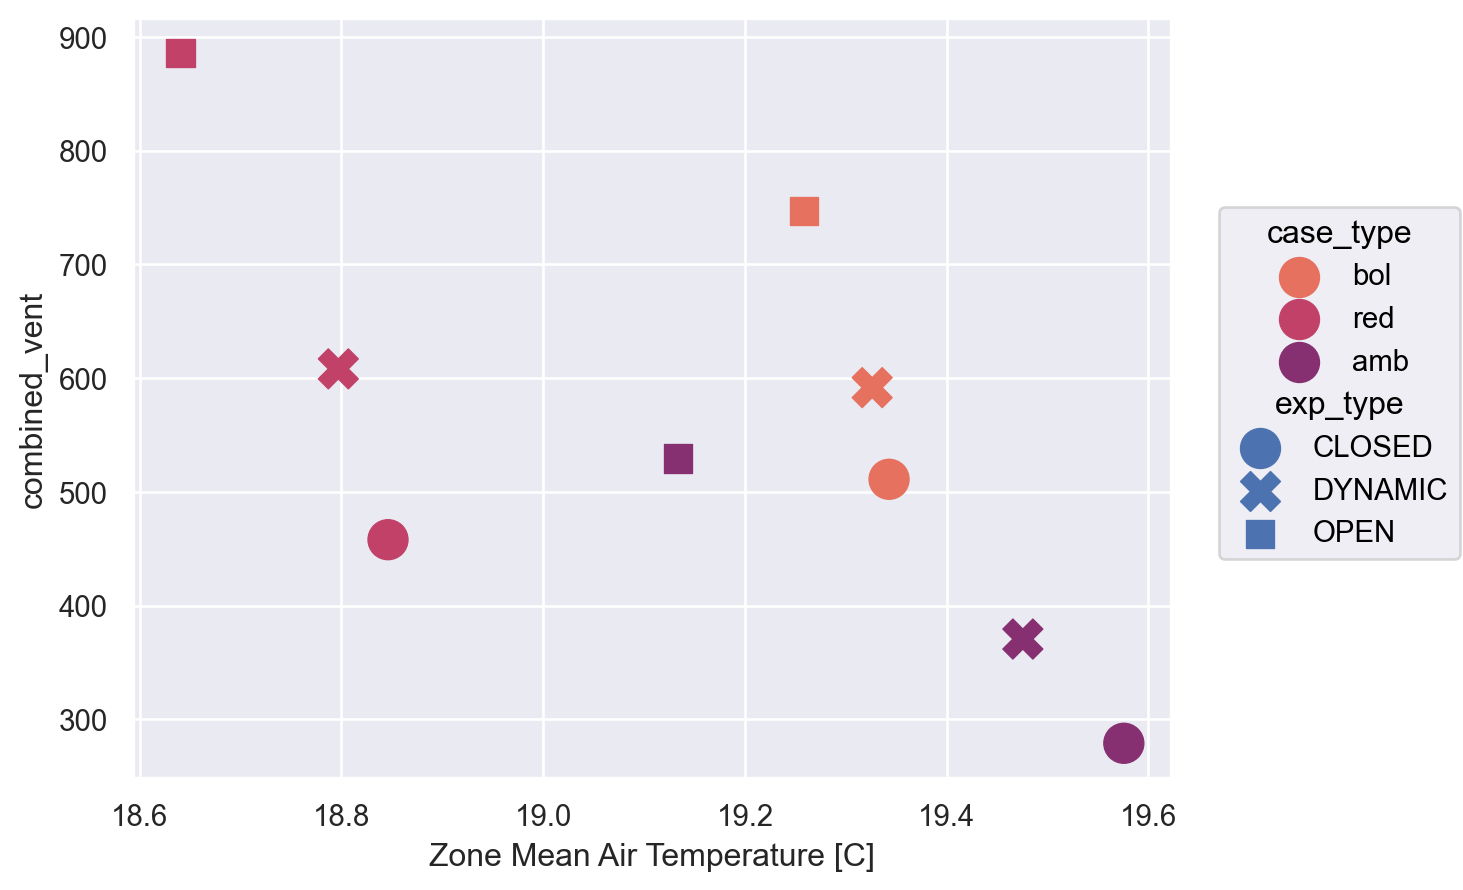

In [31]:
(so.Plot(df_agg, x="Zone Mean Air Temperature [C]", y="combined_vent", color="case_type", marker="exp_type" ).add(so.Dot(pointsize=15)).scale(color="flare").plot())
  

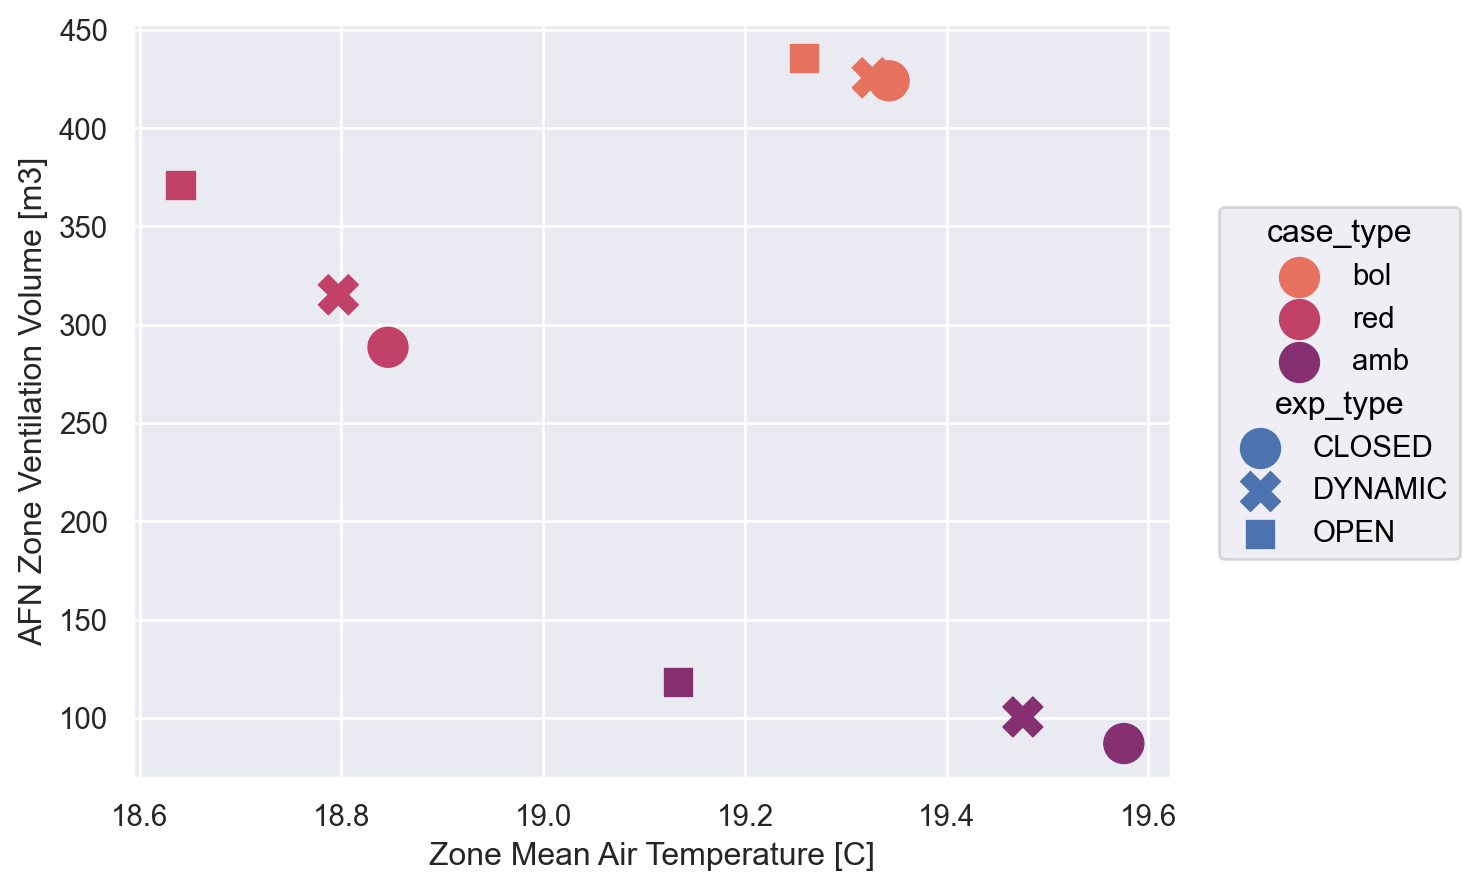

In [32]:
(so.Plot(df_agg, x="Zone Mean Air Temperature [C]", y="AFN Zone Ventilation Volume [m3]", color="case_type", marker="exp_type" ).add(so.Dot(pointsize=15)).scale(color="flare").plot())

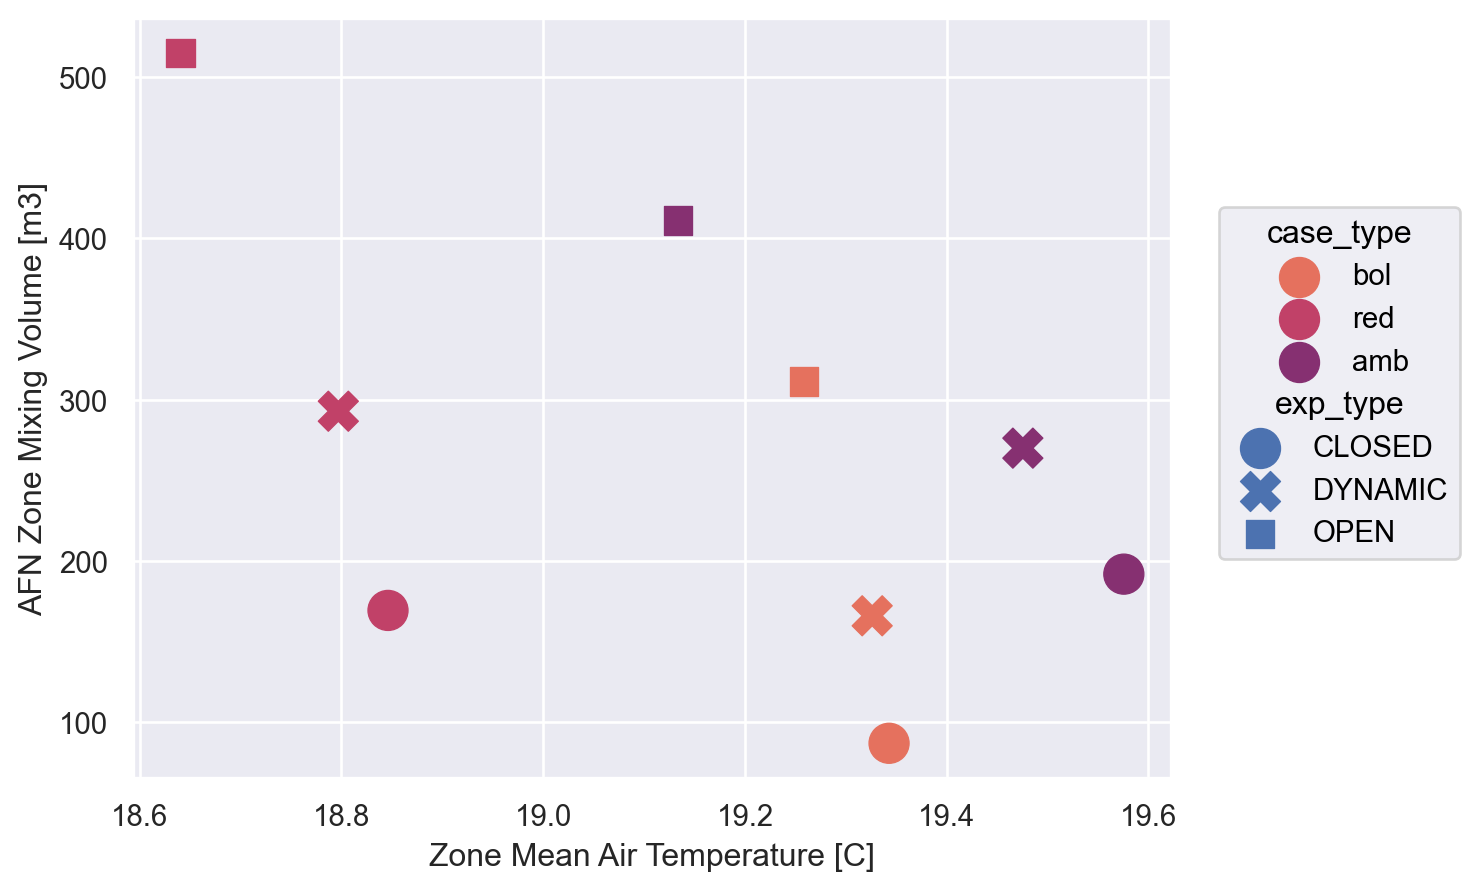

In [33]:
(so.Plot(df_agg, x="Zone Mean Air Temperature [C]", y="AFN Zone Mixing Volume [m3]", color="case_type", marker="exp_type" ).add(so.Dot(pointsize=15)).scale(color="flare").plot())